In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pywt
from scipy import signal, stats
from sklearn.preprocessing import StandardScaler

In [6]:
# Import data
df_raw = pd.read_csv("EEG-EyeBlinks/EEG-IO/S00_data.csv", delimiter=";")

In [7]:
df_raw.head()

,Time (s),FP1,FP2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Channel 11,Sampling Rate
0,0.000000,8267.955078,-8179.844238,-33746.996094,-187500.01563,187500.0,187500.0,-187500.01563,187500.0,0.0,0.0,0.0,250.0
1,0.003906,8077.987305,-8250.586914,-35346.332031,-187500.01563,187500.0,187500.0,-187500.01563,187500.0,0.0,0.0,0.0,NaN
2,0.007812,8480.788086,-8054.763672,-34270.945313,-187500.01563,187500.0,187500.0,-187500.01563,187500.0,0.0,0.0,0.0,NaN
3,0.011719,8714.296875,-7958.986328,-32953.109375,-187500.01563,187500.0,187500.0,-187500.01563,187500.0,0.0,0.0,0.0,NaN
4,0.015625,8337.893555,-8142.181641,-34229.640625,-187500.01563,187500.0,187500.0,-187500.01563,187500.0,0.0,0.0,0.0,NaN


In [8]:
df_raw.describe()

,Time (s),FP1,FP2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Channel 11,Sampling Rate
count,25568.000000,25568.000000,25568.000000,25568.000000,25568.000000,25568.0,25568.0,2.556800e+04,25568.0,25568.000000,25568.000000,25568.000000,1.0
mean,51.133508,5584.047184,-9994.350633,-25806.271649,-186124.999880,187500.0,187500.0,-1.875000e+05,187500.0,-20.663955,-10.977472,893.951189,250.0
std,29.523961,1991.421601,1010.044427,3935.817129,11497.296451,0.0,0.0,1.249161e-07,0.0,61.496339,33.802346,2625.699897,NaN
min,0.000000,1767.419434,-11964.552734,-84372.531250,-187500.015630,187500.0,187500.0,-1.875000e+05,187500.0,-304.000000,-224.000000,0.000000,250.0
25%,25.566406,3770.258606,-10886.852783,-26642.424317,-187500.015630,187500.0,187500.0,-1.875000e+05,187500.0,0.000000,0.000000,0.000000,250.0
50%,51.133789,5733.032227,-10071.818359,-25337.858399,-187500.015630,187500.0,187500.0,-1.875000e+05,187500.0,0.000000,0.000000,0.000000,250.0
75%,76.700195,7341.469360,-9124.663574,-24312.293457,-187500.015630,187500.0,187500.0,-1.875000e+05,187500.0,0.000000,0.000000,0.000000,250.0
max,102.267578,10302.701172,-7894.009766,3812.380371,-26686.886719,187500.0,187500.0,-1.875000e+05,187500.0,0.000000,16.000000,8752.000000,250.0


In [22]:
eeg_data = df_raw[['FP1', 'FP2']].values  # Get frontal channels
sfreq = 250  # Set the sampling frequency directly

array([[  8267.9550781,  -8179.8442383],
       [  8077.9873047,  -8250.5869141],
       [  8480.7880859,  -8054.7636719],
       ...,
       [  2480.6635742, -11437.655273 ],
       [  2188.548584 , -11564.725586 ],
       [  2008.7958984, -11619.978516 ]])

In [23]:
# %% Bandpass Filtering (0.5-30 Hz)
def apply_bandpass_filter(eeg_data, low=0.5, high=30, sfreq=250):
    """Apply 4th-order Butterworth bandpass filter"""
    nyq = 0.5 * sfreq
    b, a = signal.butter(4, [low/nyq, high/nyq], btype='band')
    return signal.filtfilt(b, a, eeg_data)


In [24]:
filtered_data = np.apply_along_axis(
    lambda x: apply_bandpass_filter(x) if len(x) > 27 else x, 
    1, 
    eeg_data
)

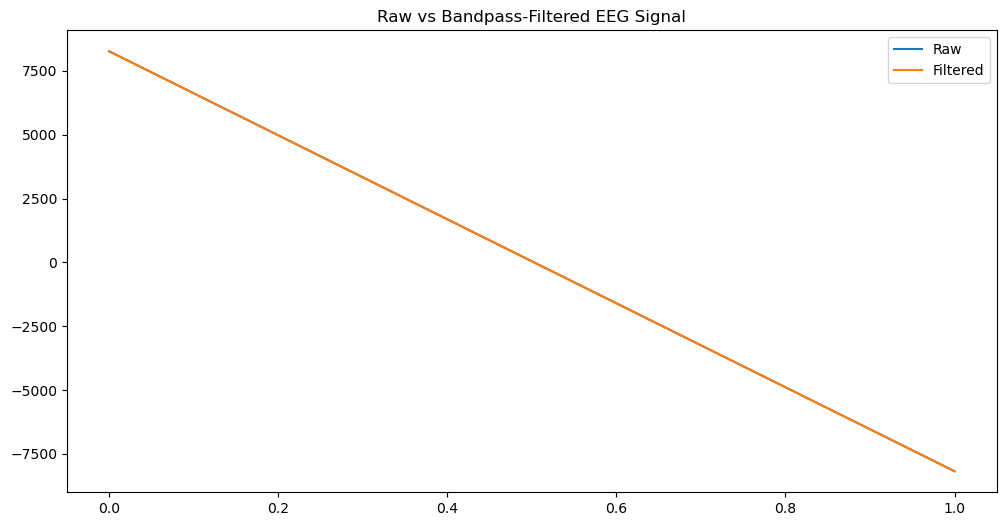

In [25]:
# Plot raw vs filtered data
plt.figure(figsize=(12, 6))
plt.plot(eeg_data[0, :500], label='Raw')
plt.plot(filtered_data[0, :500], label='Filtered')
plt.title("Raw vs Bandpass-Filtered EEG Signal")
plt.legend()
plt.show()

In [26]:
# %% Wavelet Denoising
def wavelet_denoise(signal, wavelet='db4', level=3):
    """Stationary Wavelet Transform denoising"""
    coeffs = pywt.swt(signal, wavelet, level=level)
    # Threshold detail coefficients (VisuShrink threshold)
    threshold = np.std(coeffs[-1][1]) * np.sqrt(2*np.log(len(signal)))
    coeffs = [pywt.threshold(c, threshold, mode='soft') if i > 0 else c 
              for i, c in enumerate(coeffs)]
    return pywt.iswt(coeffs, wavelet)

denoised_data = np.apply_along_axis(wavelet_denoise, 1, filtered_data)

ValueError: Level value too high (max level for current data size and start_level is 1).